<div align="left">
<img align="left" src="datasciencebowl.png" >
<div> <b> Kaggle </b></div>
<div> 2018 Data Science Bowl </div>
<div> Pedro D. Marrero Fernandez</div>
<div> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770 </div>
<div> :), :(, :/</div>
</div>

In [1]:
import os
import torch
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt


import scipy.misc
from skimage import color
from skimage import io, transform

import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as nnfun

from deep.datasets import imageutl as imutl
from deep.datasets import utility as utl
from deep.datasets import weightmaps 
from deep import netmodels as nnmodels
from deep import visualization as view
from deep import netutility as nutl
from deep import neuralnet as deepnet
from deep import postprocessing as posp
from deep import processing as proc

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Create submission pipeline

In [2]:
def imageshowlist(image_in, image_out ):    
    plt.figure( figsize=(16,16))
    plt.subplot(121)
    plt.imshow( image_in )
    plt.title('Image input')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow( image_out )
    plt.title('Image output')
    plt.axis('off')
    plt.show()

def imageshow( image, title='image'):
    plt.figure( figsize=(8,8))
    plt.imshow( image )
    plt.axis('off')
    plt.show()

### Configurate

In [3]:

# configuration
PATHDATASET = '../db'
NAMEDATASET = 'databoewl'
METADATA = 'stage1_train_labels.csv'
PATHMODEL = 'netruns/experiment_unet_fx_c0001'
NAMEMODEL = 'chk000815.pth.tar'
RLNAME = 'test_masks.csv'
NUMITER = 5
PATHNAMEDATASET = os.path.join(PATHDATASET, NAMEDATASET);
PATHNAMEDMETADATA = os.path.join(PATHDATASET, NAMEDATASET, METADATA)
PATHNAMEMODEL = os.path.join(PATHMODEL, NAMEMODEL)


### Load dataset

In [4]:
base_folder = PATHNAMEDATASET
sub_folder =  imutl.trainfile
id_file_name = METADATA
folders_image='images'
folders_masks='masks'

dataloader = imutl.dsxbProvide.create(
    base_folder, 
    sub_folder, 
    id_file_name, 
    folders_image, 
    folders_masks
    )

print(len(dataloader))
print(':)!!!')

670
:)!!!


### Create Segmentation Manager

In [5]:
segment = proc.Net(average_mirror=True)
segment.loadmodel( PATHNAMEMODEL )

>> Model loader ready ...


### Segmentation image

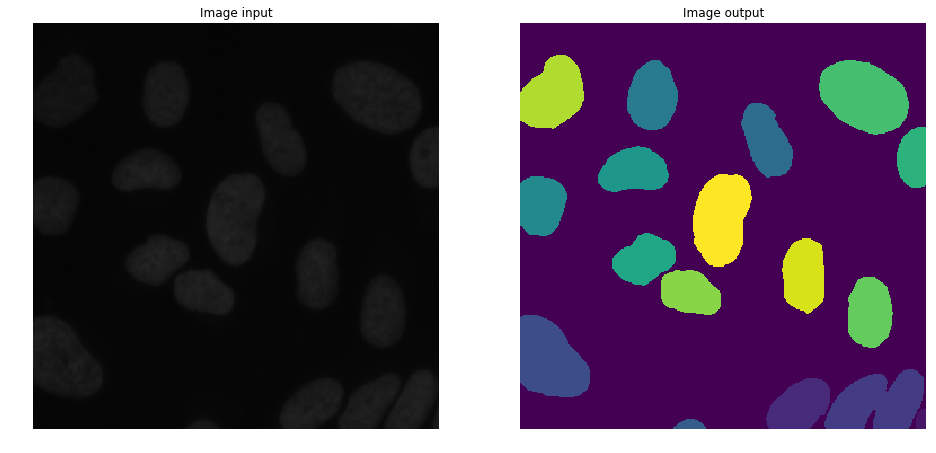

3 40 (360, 360, 3)


In [6]:
i=10 #376
image, label = dataloader[ i ]
imageshowlist( image, np.max(label, axis=2) )
nutl.summary(image)

>>
>>
DONE!!


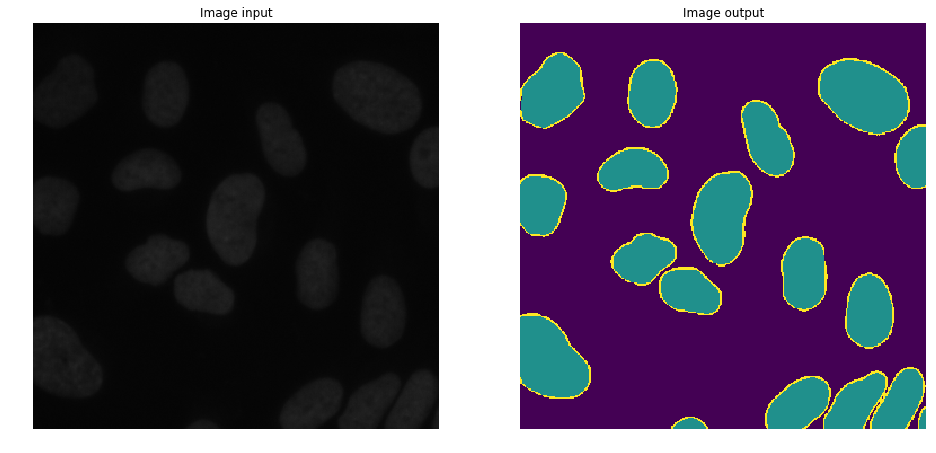

In [7]:
score = segment(image)
predition = np.argmax(score, axis=2).astype('uint8') 

print('DONE!!')
imageshowlist(image, predition)


In [8]:
print(image.shape)
print(score.shape)

(360, 360, 3)
(360, 360, 3)


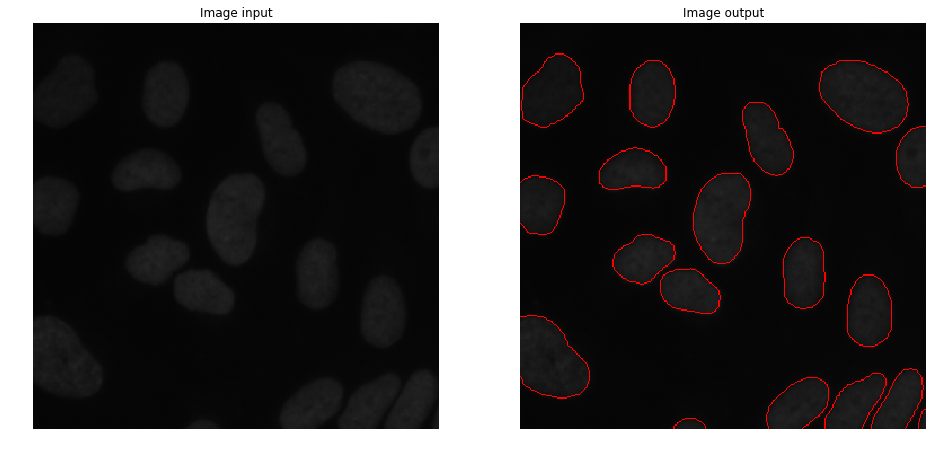

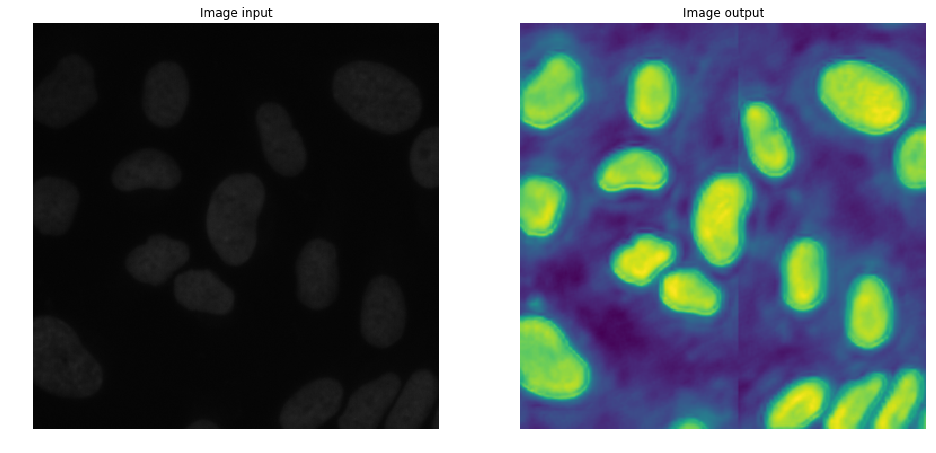

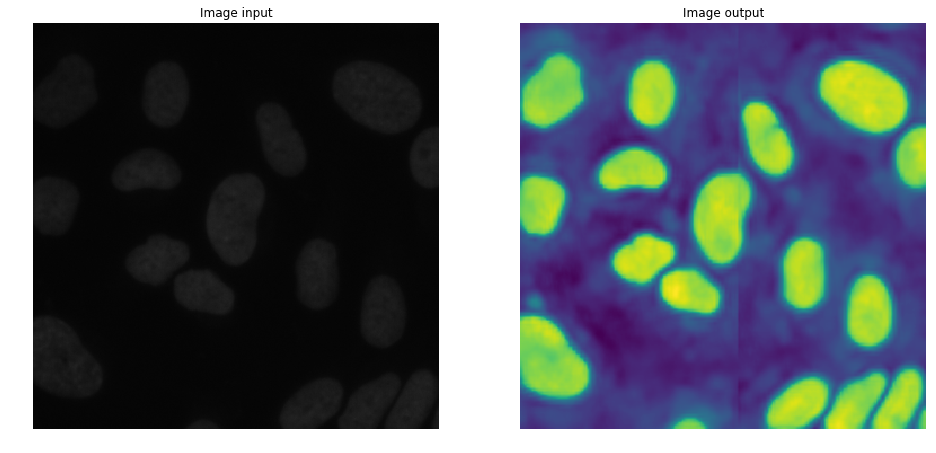

In [9]:
seginfo = nutl.process_data( score[:,:,:2], line_width=1 )

mask_line = seginfo['line_data']>0
image_sh = image.copy()
image_sh[mask_line[:,:,3],:] = [255,0,0];

imageshowlist(image, image_sh)
imageshowlist(image, score[:,:,0])
imageshowlist(image, score[:,:,1])

### Posprocessing

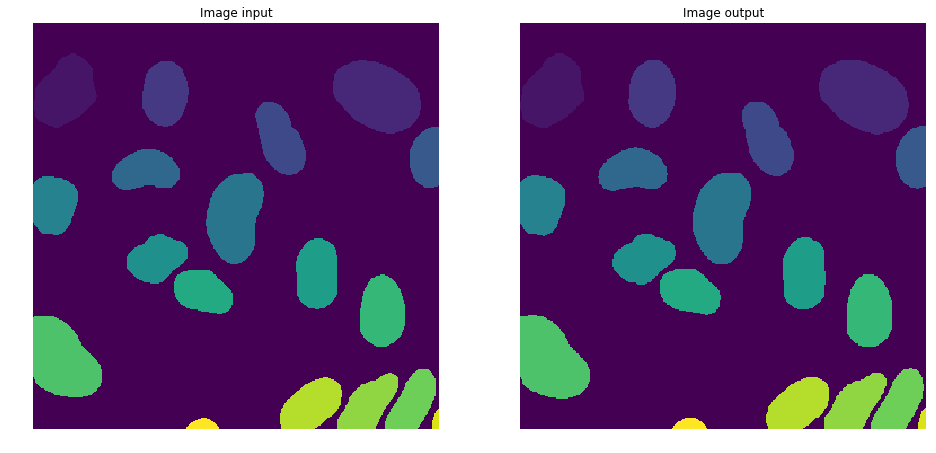

In [10]:
from skimage.filters import threshold_otsu
import skimage.morphology as morph
import scipy.ndimage as ndi

predition = np.argmax(score[:,:,:3], axis=2).astype('uint8') 
predition = predition == 1

score_prob = nutl.sigmoid(score)
m,c = score_prob[:,:,1], score_prob[:,:,2]

m_thresh = threshold_otsu(m)
c_thresh = threshold_otsu(c)
m_b = m > m_thresh
c_b = c > c_thresh

predition = ndi.binary_fill_holes(predition)
predition = morph.opening(predition,morph.disk(1))

mk, _ = ndi.label(predition)

distance = ndi.distance_transform_edt(predition)
labels = morph.watershed(-distance,  mk, mask=m_b  )

imageshowlist(mk, labels)


0 255 (360, 360, 18)


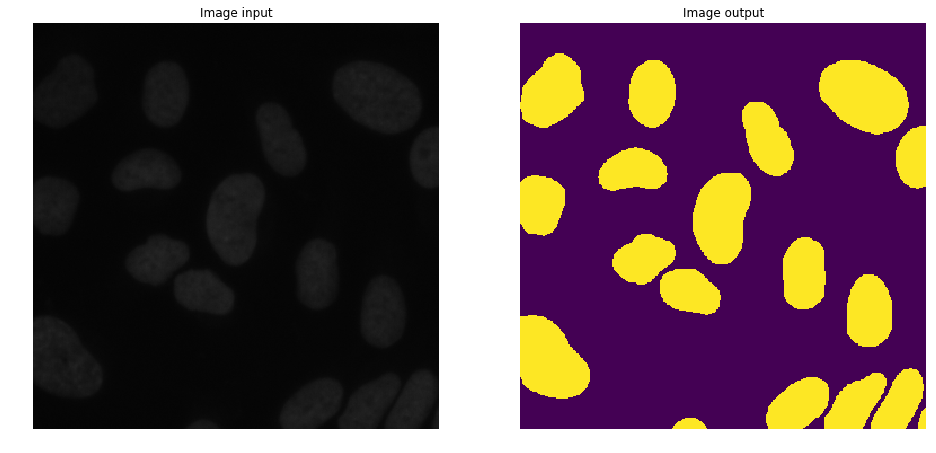

In [11]:
#score_prob = nutl.sigmoid(score)
#m,c = score_prob[:,:,1], score_prob[:,:,2]
labels_mask_est = np.transpose( posp.mpostprocess(score), (1,2,0) )
labels_est = labels_mask_est.max(axis=2)

nutl.summary(labels_mask_est)
imageshowlist(image, labels_est )

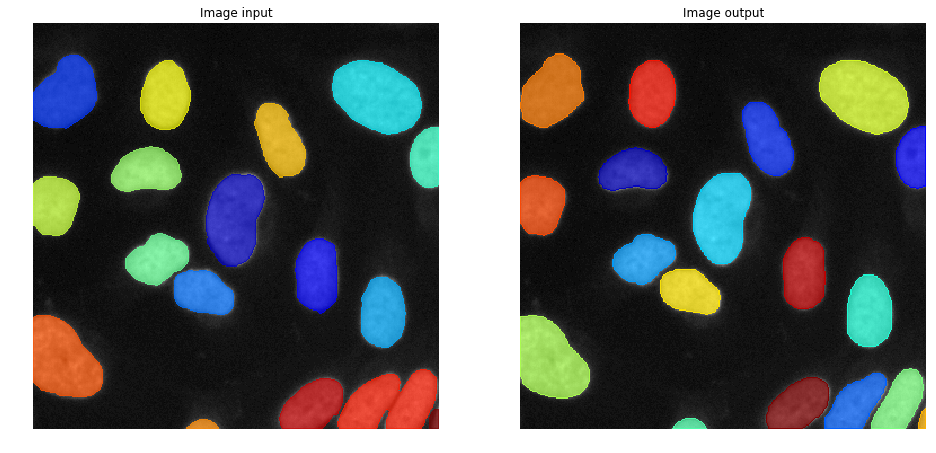

In [12]:
imagecell = view.makeimagecell(image, label, alphaback=0.7, alphaedge=0.5)
imageedge = view.makeedgecell(label)
imageback = view.makebackgroundcell(label)
maskedge = np.sum(imageedge,axis=2)>0
maskback = np.sum(imageback,axis=2)>0

labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell(image, labels_mask_est, alphaback=0.7, alphaedge=0.9)
imageshowlist(imagecell, imagecell_est )

# Metric

In [11]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from tqdm import tqdm


In [12]:
def iou(gt, pred):
    gt[gt > 0] = 1.
    pred[pred > 0] = 1.
    intersection = gt * pred
    union = gt + pred
    union[union > 0] = 1.
    intersection = np.sum(intersection)
    union = np.sum(union)
    if union == 0:
        union = 1e-09
    return intersection / union


def compute_ious(gt, predictions):
    #gt_ = decompose(gt)
    #predictions_ = decompose(predictions)
    gt_ = gt
    predictions_ = predictions
    
    gt_ = np.asarray([el.flatten() for el in gt_])
    predictions_ = np.asarray([el.flatten() for el in predictions_])
    ious = pairwise_distances(X=gt_, Y=predictions_, metric=iou)
    return ious


def compute_precision_at(ious, threshold):
    mx1 = np.max(ious, axis=0)
    mx2 = np.max(ious, axis=1)
    tp = np.sum(mx2 >= threshold)
    fp = np.sum(mx2 < threshold)
    fn = np.sum(mx1 < threshold)
    return float(tp) / (tp + fp + fn)


def compute_eval_metric(gt, predictions):
    thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    ious = compute_ious(gt, predictions)
    precisions = [compute_precision_at(ious, th) for th in thresholds]
    return sum(precisions) / len(precisions)




In [30]:

y_true = label.transpose( (2,0,1) )
y_pred = labels_mask_est.transpose( (2,0,1) )
#y_pred = dummy.transpose( (2,0,1) )

nutl.summary(y_true)
nutl.summary(y_pred)

ious = compute_ious(y_true, y_pred)
iou_mean = 1.0 * np.sum(ious) / ious.shape[0]
print(iou_mean)

iout = compute_eval_metric(y_true, y_pred)
print(iout)


0.0 23.0 (23, 360, 360)
0 255 (22, 360, 360)
0.710680245606
0.448849590275


In [62]:
y_pred.shape
labels_mask_est.shape

(256, 320, 11)

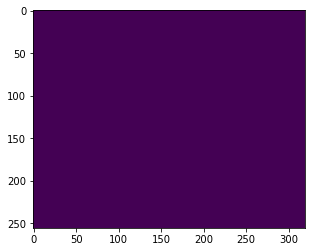

[1, 1]


In [66]:

def get_dummy_solution( data, marge=2 ):
    data[marge:data.shape[0]-marge+1,marge:data.shape[1]-marge+1] = 1
    return data
 
mask = np.zeros( (256,320) )
dummy = mask #  get_dummy_solution( mask, marge=0 )
dummy[0,0] = 1

plt.imshow(dummy)
plt.show()

rle = nutl.rle_encode( dummy )
print(rle)

dummy = dummy[:,:,np.newaxis]

### Submission

In [15]:

experiments_dir = '.'

rles = list()
for i in range( labels_est.shape[2] ):      
    idimage = dataloader.getid()
    rle = nutl.rle_encode(labels_est[:,:,i])    
    rles.append( {'ImageId':idimage, 'EncodedPixels':rle } )

submission = pd.DataFrame(rles).astype(str)
submission = submission[submission['EncodedPixels']!='nan']
submission_filepath = os.path.join(experiments_dir, 'submission.csv')
submission.to_csv(submission_filepath, index=None, encoding='utf-8')

print(submission.head())

                                       EncodedPixels  \
0  1206 1 1459 7 1714 10 1968 13 2223 16 2478 18 ...   
1  60625 7 60877 15 61132 18 61387 22 61642 24 61...   
2  22954 8 23208 20 23464 22 23719 25 23975 25 24...   
3  36330 8 36583 13 36838 15 37093 17 37349 17 37...   
4  5311 11 5566 14 5822 15 6078 16 6334 17 6590 1...   

                                             ImageId  
0  0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb...  
1  0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb...  
2  0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb...  
3  0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb...  
4  0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb...  


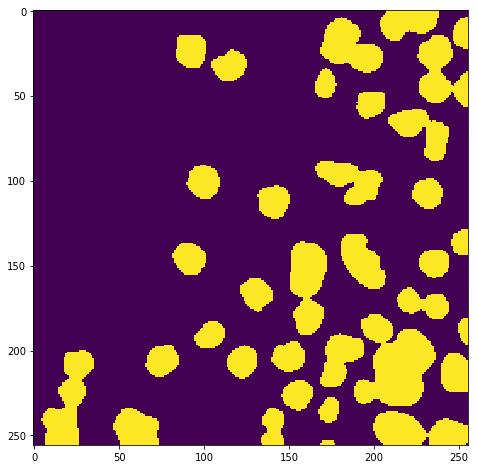

In [17]:
h,w = image.shape[:2]
rlelabel = np.zeros( (h,w) )
for i in range( len(rles) ):
    rlelabel += nutl.rle_decode(rles[i]['EncodedPixels'].split(),(h,w))

plt.figure( figsize=(8,8) )
plt.imshow( rlelabel )
plt.show()